In [1]:
# reset variables
%reset -f

import os, sys

ROOT_PATH = os.path.abspath(".").split("src")[0]

module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
module_path_venv = os.path.abspath(os.path.join(ROOT_PATH+"/venv/lib/python3.6/site-packages/"))
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.append(module_path_venv)

import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import rc
from matplotlib import pyplot as plt
from scipy import stats

from settings import UPPER_ANOMALY_THRESHOLD
from settings import LOWER_ANOMALY_THRESHOLD
from settings import NUM_AVERAGED_ANOMALY_SCORES
from settings import INPUT_FILE_PATH_TRAIN
from settings import INPUT_FILE_PATH_TEST
from settings import MIN_NUMBER_OF_RESIDUALS
from settings import MODEL_PATH
from settings import START
     
from sklearn.linear_model import LinearRegression
from functions import MAE, RMSE, split_dataset

import keras
import tensorflow as tf
import functions as f
import dl_functions as dlf

SEED=100
np.random.seed(SEED)
tf.set_random_seed(SEED)

Using TensorFlow backend.


In [2]:
# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

In [3]:
# read data and metadata
df_train, df_valid, df_test, df_anomaly = f.load_data()
stats_set, ts, ts_train, ts_valid, ts_test, ts_anomaly = f.load_metadata()

# split datasets into features and targets
x_train, y_train = f.split_dataset(df_train.values, delay=1)
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_test, y_test = f.split_dataset(df_test.values, delay=1)
x_anomaly, y_anomaly = f.split_dataset(df_anomaly.values, delay=1)

# metadata
target_tags = df_train.columns.values[:3]
feature_tags = df_train.columns.values[3:]
target_stds = stats_set.loc[target_tags,"Std"].values

In [5]:
# load the model
x_pred = x_anomaly
y_pred = y_anomaly

model = dlf.load_keras_model(ROOT_PATH+"models/lstm_128/50/")

# predict with the model
predicted_train, std_preds, pred_dict = dlf.predict_with_model(model, x_valid, y_valid, n_predictions=40)
y_hat, std_preds, pred_dict = dlf.predict_with_model(model, x_pred, y_pred, n_predictions=40)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
# Create residual distribution
def create_residual_distribution(signal, plot = True):
    N = 5

    res_dist = predicted_train[:,signal][:MIN_NUMBER_OF_RESIDUALS] - y_train[:,signal][:MIN_NUMBER_OF_RESIDUALS]
    exp_smoothed = np.ravel(
        pd.DataFrame(
            res_dist
        ).ewm(alpha = 0.6).mean().values
    )
    rolling_smoothed = pd.Series(res_dist).rolling(window=N).mean().iloc[N-1:].values

    if plot:
        positions = [131, 132, 133]
        fig = plt.figure()
        fig.suptitle('Signal: {}'.format(signal), fontsize=16)
        axs = [fig.add_subplot(i) for i in positions]
        axs[0].hist(res_dist, label="Residual dist.")
        axs[1].hist(exp_smoothed, label="Exp. smoothed")
        axs[2].hist(rolling_smoothed, label="Rolling. smoothed")
        [ax.legend(frameon=True) for ax in axs]
        
    return rolling_smoothed

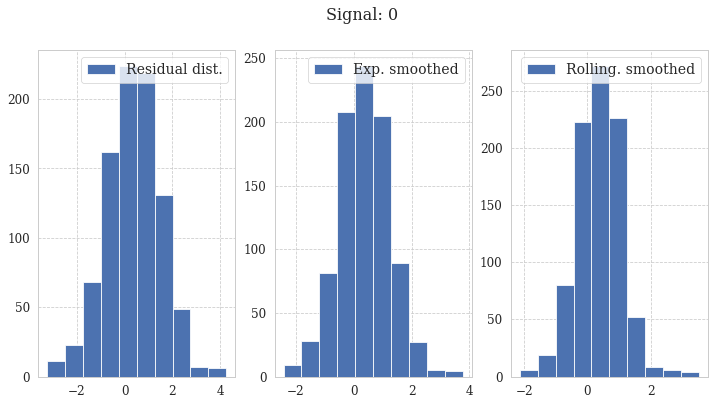

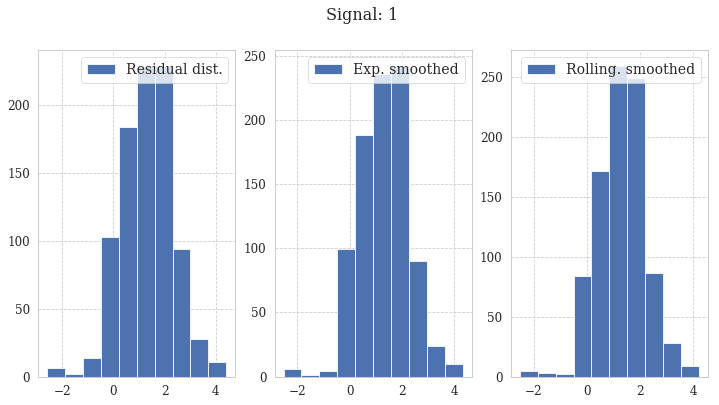

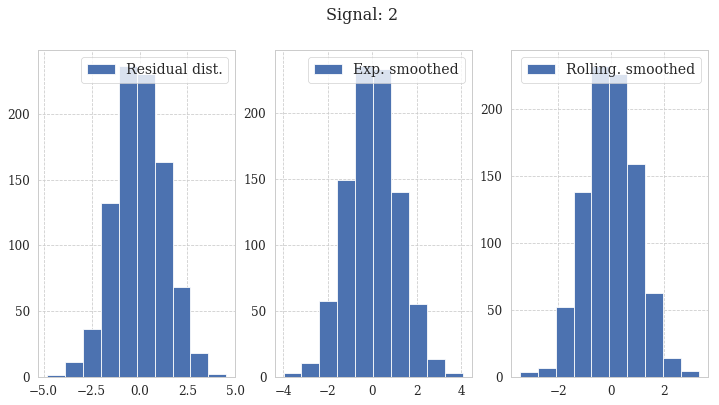

In [7]:
res = [create_residual_distribution(
            signal = i,
            plot = True
        ) for i in range(0,3)
      ]

## Define anomalies

In [145]:
len(y_pred[:,0][::5][START:END])

SyntaxError: invalid syntax (<ipython-input-145-7607b23e53cb>, line 1)

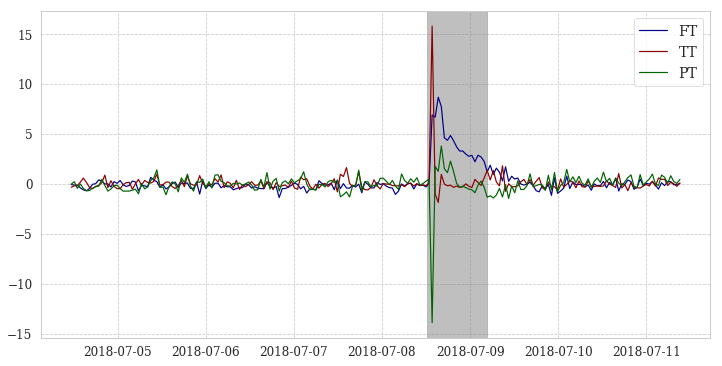

In [232]:
START = 5000
END = 15000
DELTA = 50

tau = 4
x = ts_anomaly[START:END]

anomaly_flow_start = np.where(abs(y_pred[:, 0][START:END]) > tau)[0][0] + START
anomaly_flow_end = np.where(abs(y_pred[:, 0][START:END]) > tau)[0][-1] + START

anomaly_temp_start = np.where(abs(y_pred[:, 1][START:END]) > tau)[0][0] + START
anomaly_temp_end = np.where(abs(y_pred[:, 1][START:END]) > tau)[0][-1] + START

anomaly_pres_start = np.where(abs(y_pred[:, 2][START:END]) > tau)[0][0] + START
anomaly_pres_end = np.where(abs(y_pred[:, 2][START:END]) > tau)[0][-1] + START

anomaly_range_start = min(anomaly_flow_start, anomaly_temp_start, anomaly_pres_start)
anomaly_range_end = max(anomaly_flow_end, anomaly_temp_end, anomaly_pres_end)

anomaly_range = x[range(anomaly_range_start - START - 50, anomaly_range_end - START + 500)] 

positions = [111]
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,1,1)
ax.plot(x[::DELTA], y_pred[:,0][START:END][::DELTA], label="FT", c = "darkblue")
ax.plot(x[::DELTA], y_pred[:,1][START:END][::DELTA], label="TT", c = "darkred")
ax.plot(x[::DELTA], y_pred[:,2][START:END][::DELTA], label="PT", c = "darkgreen")
ax.axvspan(anomaly_range[0], anomaly_range[-1], alpha=0.5, color='grey')
ax.legend()

## Probabilistic anomaly detection

In [283]:
# Plot results
def plot_probabilistic_anomalies(anomaly_likelihoods, signal = 0, verbose = True):
    UPPER_ANOMALY_THRESHOLD = 0.99 if not log_likelihood else 0.6

    x = ts_anomaly[START:END]
    
    num_points_in_anomaly_range = np.sum(anomaly_indexes[START:END])
    predicted_anomalies = anomaly_likelihoods[START:END] > UPPER_ANOMALY_THRESHOLD
    
    anomaly_range_start = np.where(x == anomaly_range[0])[0][0]
    anomaly_range_end = np.where(x == anomaly_range[-1])[0][0]
    in_range_anomalies = anomaly_likelihoods[START + anomaly_range_start:anomaly_range_end + START] > UPPER_ANOMALY_THRESHOLD
    
    positions = [411, 412]
    
    fig = plt.figure(figsize=(16, 12))
    
    axs = [fig.add_subplot(i) for i in positions]

    axs[0].plot(
        x, 
        anomaly_likelihoods[START:END],
        c='darkblue', 
        lw=0,
        marker='o',
        ms=1,
        label = "Log Anomaly Likelihood"
    )
    
    axs[0].axhline(
        y=UPPER_ANOMALY_THRESHOLD, 
        c='darkred', 
        linestyle='--'
    )
    
    axs[0].set_ylim(0, 1.05)
    axs[0].axvspan(anomaly_range[0], anomaly_range[-1], alpha=0.5, color='grey')


    axs[1].plot(
        x[::DELTA],
        y_pred[:,signal][START:END][::DELTA], 
        c="darkgreen", 
        label = "Actual"
    )
    axs[1].plot(
        x[::DELTA], 
        y_hat[:, signal][START:END][::DELTA], 
        c="darkblue", 
        label = "Predicted"
    )
    axs[1].set_ylim(-10, 10)
    
    axs[1].axvspan(anomaly_range[0], anomaly_range[-1], alpha=0.5, color='grey')
    
    red_marks = x[np.where((anomaly_likelihoods[START:END] > UPPER_ANOMALY_THRESHOLD) == True)[0]]
    
    [axs[1].axvspan(red_marks[i], red_marks[i+1], alpha=0.1, color='red') for i in range(0, len(red_marks) - 1)]

    [ax.legend(frameon=True) for ax in axs]
    
    if verbose:
        print(\
            'Total number of points in anomaly range: {num_points_in_anomaly_range} \n Total number of flagged anomalies:  {num_flagged} \n In range anomalies: {in_range_anomalies} \n Out of range anomalies: {out_of_range_anomalies}'.format(
                num_points_in_anomaly_range = num_points_in_anomaly_range,
                num_flagged = np.sum(predicted_anomalies),
                in_range_anomalies = np.sum(in_range_anomalies),
                out_of_range_anomalies = np.sum(predicted_anomalies) - np.sum(in_range_anomalies)
        ))

Total number of points in anomaly range: 0 
 Total number of flagged anomalies:  400 
 In range anomalies: 400 
 Out of range anomalies: 0


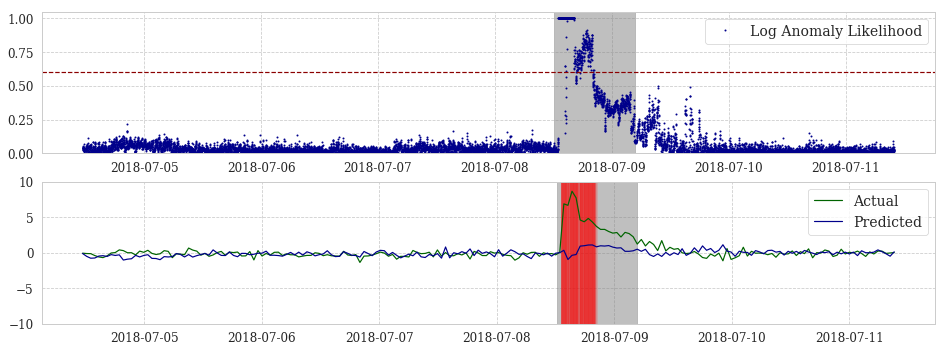

In [284]:
signal = 0
plot_probabilistic_anomalies(anomaly_likelihoods = anomaly_likelihoods[signal], signal = signal)

In [285]:
def tailProbability(x, mu, sigma):
    z = (x - mu) / sigma
    return 1.0 - 0.5 * math.erfc(z / np.sqrt(2))

def calculate_anomaly_score(residuals):
     return pd.DataFrame(
        residuals, 
        columns = ['res']
    ).ewm(alpha = 0.5).mean()['res'].values[-1]
    

def calculate_anomaly_likelihood(
    residuals,
    y, 
    y_hat, 
    mu,
    sigma,
    model = model,
):
    anomaly_score = calculate_anomaly_score(residuals = residuals)
    anomaly_likelihood = tailProbability(anomaly_score, mu, sigma)
    
    if log_likelihood:
        return np.log(1.0000000001 - 2 * abs(0.5 - anomaly_likelihood)) / np.log(1.0 - 0.9999999999)
    else:
        return abs(0.5 - anomaly_likelihood)

In [286]:
log_likelihood = True
NUM_AVERAGED_ANOMALY_SCORES = 6

residuals = np.zeros(len(y_hat))
anomaly_likelihoods = [np.zeros(len(y_hat)) for i in range (0, 3)]

def run(plot = True):
    for signal in range(0, 3):
        res_dist = create_residual_distribution(signal = signal, plot = False)
        (mu, sigma) = getattr(stats, 'norm').fit(res_dist)
        
        for index in range(START, END):    
            residual = y_hat[:,signal][index] - y_pred[:,signal][index]
            residuals[index] = residual
            
            anomaly_likelihoods[signal][index] = calculate_anomaly_likelihood(
                residuals = residuals[(index - NUM_AVERAGED_ANOMALY_SCORES): (index + 1)],
                y = y_pred,
                y_hat = y_hat,
                mu = mu,
                sigma = sigma
            )
        
        if plot:
            plot_probabilistic_anomalies(signal = signal, anomaly_likelihoods = anomaly_likelihoods[signal])
        
    return anomaly_likelihoods

Total number of points in anomaly range: 0 
 Total number of flagged anomalies:  400 
 In range anomalies: 400 
 Out of range anomalies: 0
Total number of points in anomaly range: 0 
 Total number of flagged anomalies:  80 
 In range anomalies: 80 
 Out of range anomalies: 0
Total number of points in anomaly range: 0 
 Total number of flagged anomalies:  80 
 In range anomalies: 80 
 Out of range anomalies: 0


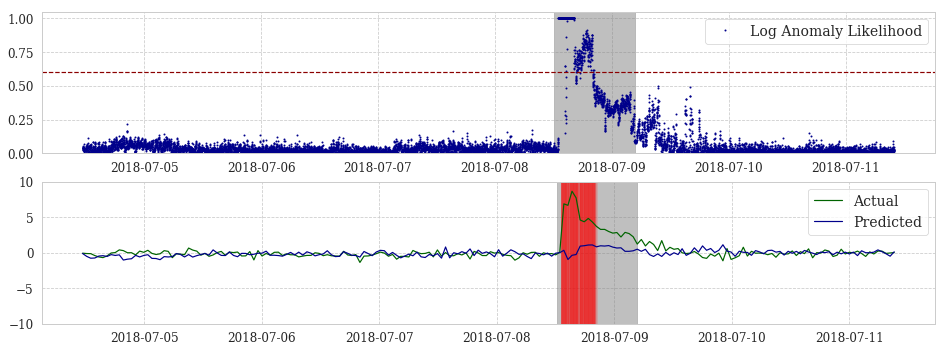

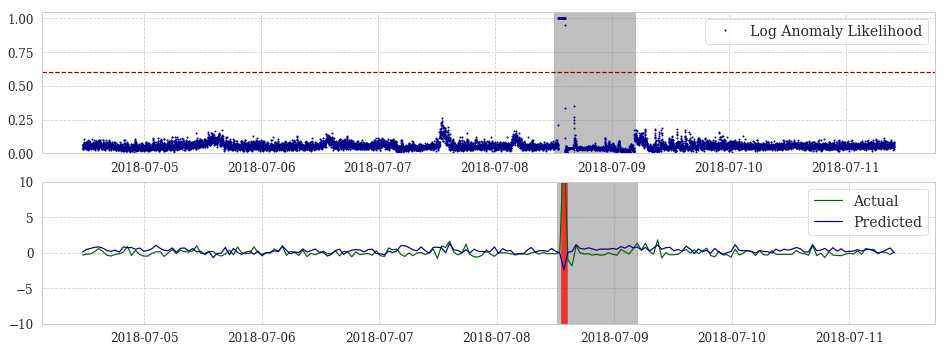

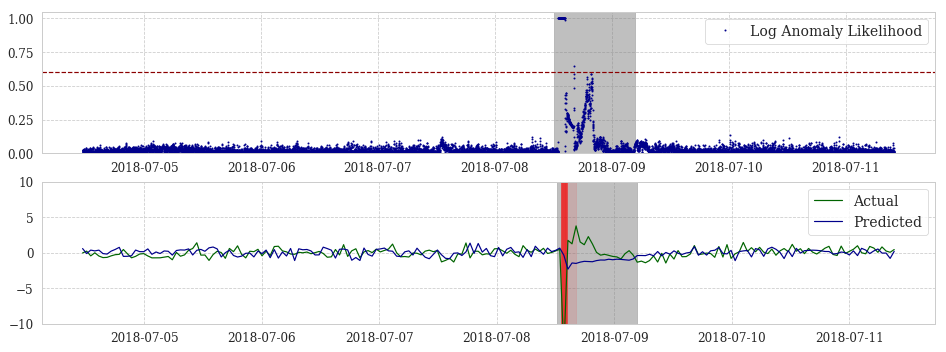

In [287]:
anomaly_likelihoods = run()

## PI Anomaly Detection

Total number of points in anomaly range: 0 
 Total number of flagged anomalies:  44 
 In range anomalies: 3 
 Out of range anomalies: 41
Total number of points in anomaly range: 0 
 Total number of flagged anomalies:  96 
 In range anomalies: 78 
 Out of range anomalies: 18
Total number of points in anomaly range: 0 
 Total number of flagged anomalies:  108 
 In range anomalies: 81 
 Out of range anomalies: 27


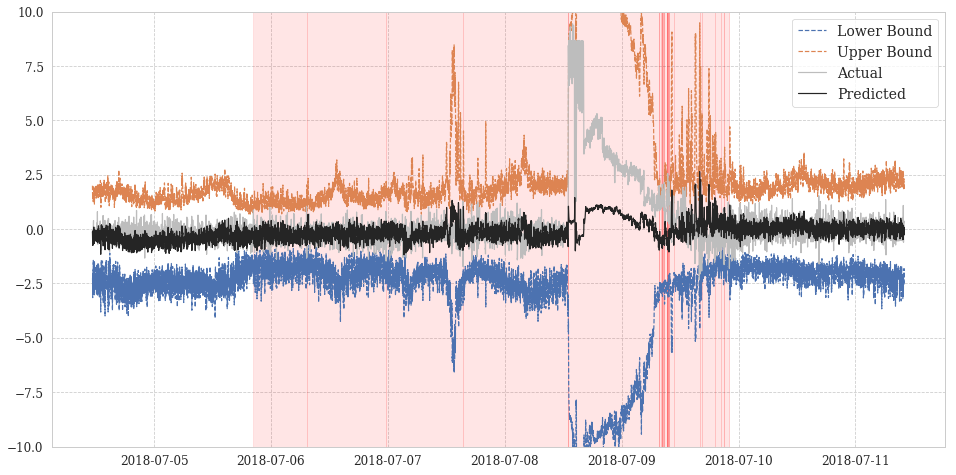

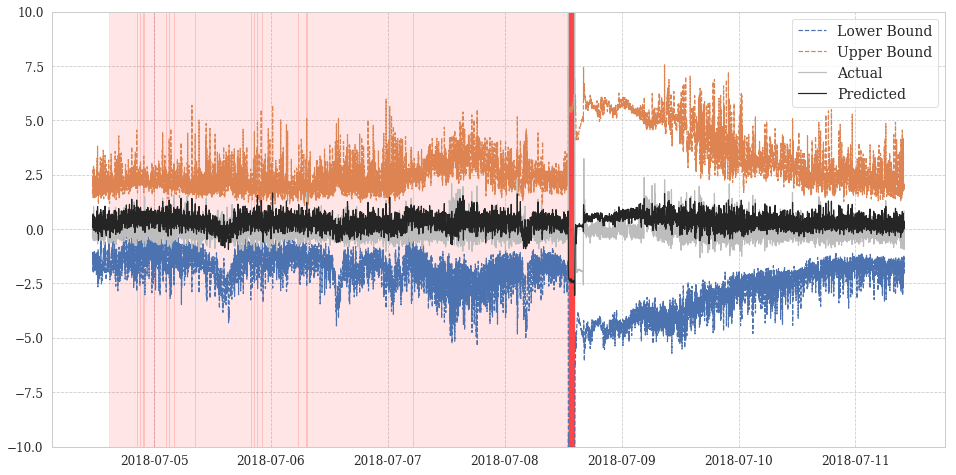

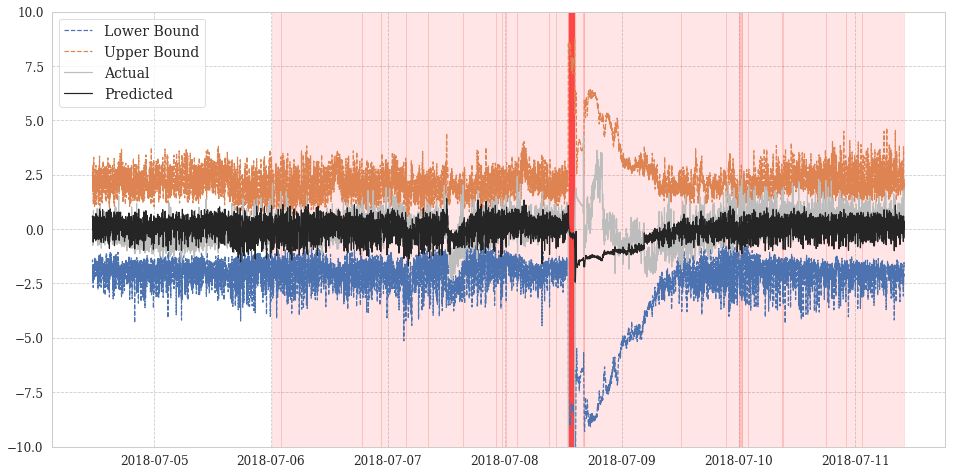

In [314]:
START = 5000
END = 15000

def pi_anomaly_detection(verbose = True):
    for signal in range(0,3):
        alpha = 10
        
        x = ts_anomaly[START:END]
        anomaly_range_start = np.where(x == anomaly_range[0])[0][0] + START
        anomaly_range_end = np.where(x == anomaly_range[-1])[0][0] + START
        positions = [411, 412]
    
        
        lower_pi = y_hat[:, signal] - alpha * std_preds[:, signal]
        upper_pi = y_hat[:, signal] + alpha * std_preds[:, signal]
    
        anomaly_range_start = np.where(x == anomaly_range[0])[0][0]
        anomaly_range_end = np.where(x == anomaly_range[-1])[0][0]

        num_points_in_anomaly_range = np.sum(anomaly_indexes[START:END])
        predicted_anomalies = [
            y_pred[:, signal][START:END][i] > upper_pi[START:END][i] or 
            y_pred[:, signal][START:END][i] < lower_pi[START:END][i] for i in range(0, END - START)
        ]
        
        in_range_anomalies = predicted_anomalies[anomaly_range_start:anomaly_range_end]
    
        positions = [111]
        fig = plt.figure(figsize=(16, 8))
        axs = [fig.add_subplot(i) for i in positions]

        axs[0].plot(x, lower_pi[START:END], linestyle='--', label = "Lower Bound")
        axs[0].plot(x, upper_pi[START:END], linestyle='--', label = "Upper Bound")
        axs[0].plot(x, y_pred[:, signal][START:END], label = "Actual", color="#bdbdbd")
        axs[0].plot(x, y_hat[:, signal][START:END], label = "Predicted", color="#252525")
        axs[0].set_ylim(-10, 10)
        red_marks = x[predicted_anomalies]    
        [axs[0].axvspan(red_marks[i], red_marks[i+1], alpha=0.1, color='red') for i in range(0, len(red_marks) - 1)]
    

        [ax.legend() for ax in axs]

        if verbose:
            print(\
                'Total number of points in anomaly range: {num_points_in_anomaly_range} \n Total number of flagged anomalies:  {num_flagged} \n In range anomalies: {in_range_anomalies} \n Out of range anomalies: {out_of_range_anomalies}'.format(
                    num_points_in_anomaly_range = num_points_in_anomaly_range,
                    num_flagged = np.sum(predicted_anomalies),
                    in_range_anomalies = np.sum(in_range_anomalies),
                    out_of_range_anomalies = np.sum(predicted_anomalies) - np.sum(in_range_anomalies)
            ))

pi_anomaly_detection()

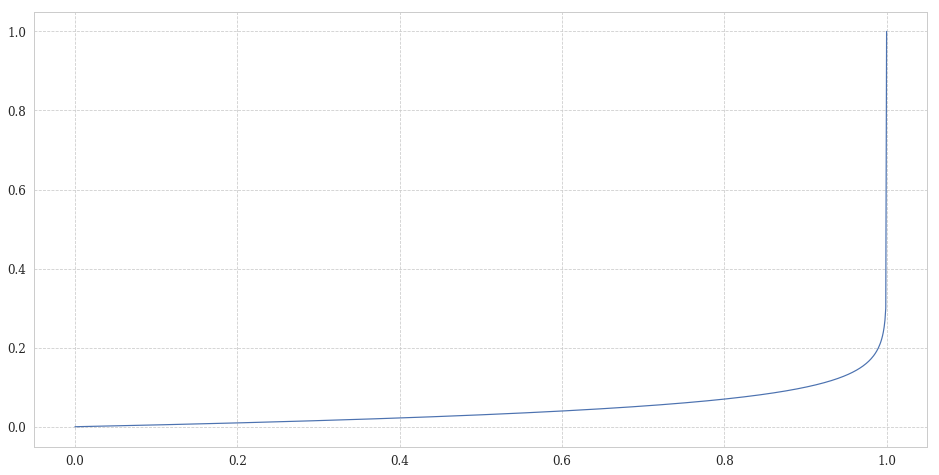

In [245]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(np.linspace(0, 1.0, 1000), np.log(1.0000000001 - np.linspace(0, 1.0, 1000)) / np.log(1.0 - 0.9999999999))
plt.show()